In [2]:
import pandas as pd
# loads X train dataset (features of each instance)
x_train = pd.read_csv('CompleteDataSet/x_train_all.csv')
# load Y train dataset (classes of each instance)
y_train=pd.read_csv('CompleteDataSet/y_train_all.csv')

x_train.shape

(9690, 2304)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns



### Create Diff kinds of dataframe


##### PCA

In [38]:
n_components = 1500  # Adjust this number as needed
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(x_train)


##### Pre-Processed

In [5]:
import scipy.ndimage as ndi
import cv2

def apply_clahe(row):
    row = np.array(row, dtype=np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_row = clahe.apply(row)
    return equalized_row

def brighten(row, target_mean_brightness=128, max_brightness_adjustment=50):
    current_mean_brightness = np.mean(row)
    brightness_adjustment = target_mean_brightness - current_mean_brightness
    brightness_adjustment = np.clip(brightness_adjustment, -max_brightness_adjustment, max_brightness_adjustment)
    scaling_factor = (current_mean_brightness + brightness_adjustment) / current_mean_brightness
    adjusted_row = row * scaling_factor
    adjusted_row[adjusted_row < 0] = 0
    adjusted_row[adjusted_row > 255] = 255
    return adjusted_row
    
def apply_gamma_correction(row, gamma=1.8):
    input_shape = row.shape
    row = np.array(row, dtype=np.uint8)
    corrected_row = ((row / 255.0) ** (1 / gamma) * 255).astype(np.uint8)
    corrected_row = corrected_row.reshape(*input_shape) 
    return corrected_row

def add_noise(row, noise_level=20):
    row = row + noise_level * np.random.randn(*row.shape)
    row[row < 0] = 0
    row[row > 255] = 255
    return row

def apply_gaussian_blur(row, kernel_size=(5, 5), sigma=0):
    row = np.array(row, dtype=np.uint8)
    row = cv2.GaussianBlur(row, kernel_size, sigma)
    return row

In [145]:
x_copy = x_train.copy()
processed_images = []

for i, idx in enumerate(x_copy.index):
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    brightened_image = brighten(x_copy.iloc[idx].values).reshape(48, 48)
    gamma_image = apply_gamma_correction(brightened_image)
    noisy_image = add_noise(gamma_image)
    gaussian_image = apply_gaussian_blur(brightened_image)
    equalized_image = apply_clahe(gamma_image)

    processed_images.append(equalized_image.flatten())

processed_df = pd.DataFrame(processed_images)
processed_df.shape

(9690, 2304)

In [138]:
# processed_df.to_csv('processed_df.csv', index=False)

In [139]:
# processed_df = pd.read_csv('processed_df.csv')

### Create Clustering Algos


##### Agglomerative Clustering

In [78]:
agg_clustering_raw = AgglomerativeClustering(n_clusters=5)


agglo_labels_raw = agg_clustering_raw.fit_predict(x_train)

In [79]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(x_train, agglo_labels_raw)
print(silhouette_avg)

0.20393837995988515


In [39]:
agg_clustering_pca = AgglomerativeClustering(n_clusters=10)


agg_clustering_pca.fit(X_pca)
agglo_labels_pca = agg_clustering_pca.labels_

In [40]:
silhouette_avg_pca = silhouette_score(X_pca, agglo_labels_pca)
print(silhouette_avg_pca)

0.128539298647167


In [146]:
agg_clustering_preproc = AgglomerativeClustering(n_clusters=10)


agg_clustering_preproc.fit(processed_df)
agglo_labels_preproc = agg_clustering_preproc.labels_

In [147]:
silhouette_avg_pre = silhouette_score(processed_df, agglo_labels_preproc)
print(silhouette_avg_pre)

0.025820399805277085


In [14]:
processed_df.shape

(9690, 2304)

In [41]:
X_pca.shape

(9690, 1500)

In [42]:
from sklearn.metrics import accuracy_score

acc_pca = accuracy_score(y_true=y_train, y_pred= agglo_labels_pca)
acc_pca

0.14912280701754385

In [25]:
acc_raw = accuracy_score(y_true=y_train, y_pred= agglo_labels_raw)
acc_raw

0.14035087719298245

In [148]:
acc_preproc = accuracy_score(y_true=y_train, y_pred= agglo_labels_preproc)
acc_preproc

0.1265221878224974

##### DBSCAN


-1


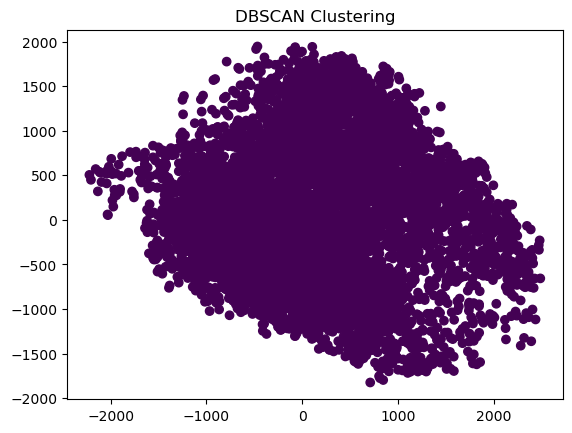

In [63]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2000)
data = pca.fit_transform(processed_df)


dbscan = DBSCAN(eps=0.01, min_samples=50)
dbscan.fit(data)


labels = dbscan.labels_
print(labels.max())

plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.title("DBSCAN Clustering")
plt.show()




In [152]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

data = x_train


n_components = 10  
gmm = GaussianMixture(n_components=n_components, random_state=10)
cluster_labels = gmm.fit_predict(data)





In [153]:
ari_score = adjusted_rand_score(y_train.to_numpy().ravel(), cluster_labels)  

silhouette_avg = silhouette_score(data, cluster_labels)

print(f"Adjusted Rand Index (ARI): {ari_score}")
print(f"Silhouette Score: {silhouette_avg}")

Adjusted Rand Index (ARI): 0.04305419825777303
Silhouette Score: 0.13864192405409909


In [154]:
acc_preproc = accuracy_score(y_true=y_train, y_pred= cluster_labels)
acc_preproc

0.09195046439628483

### Visualise


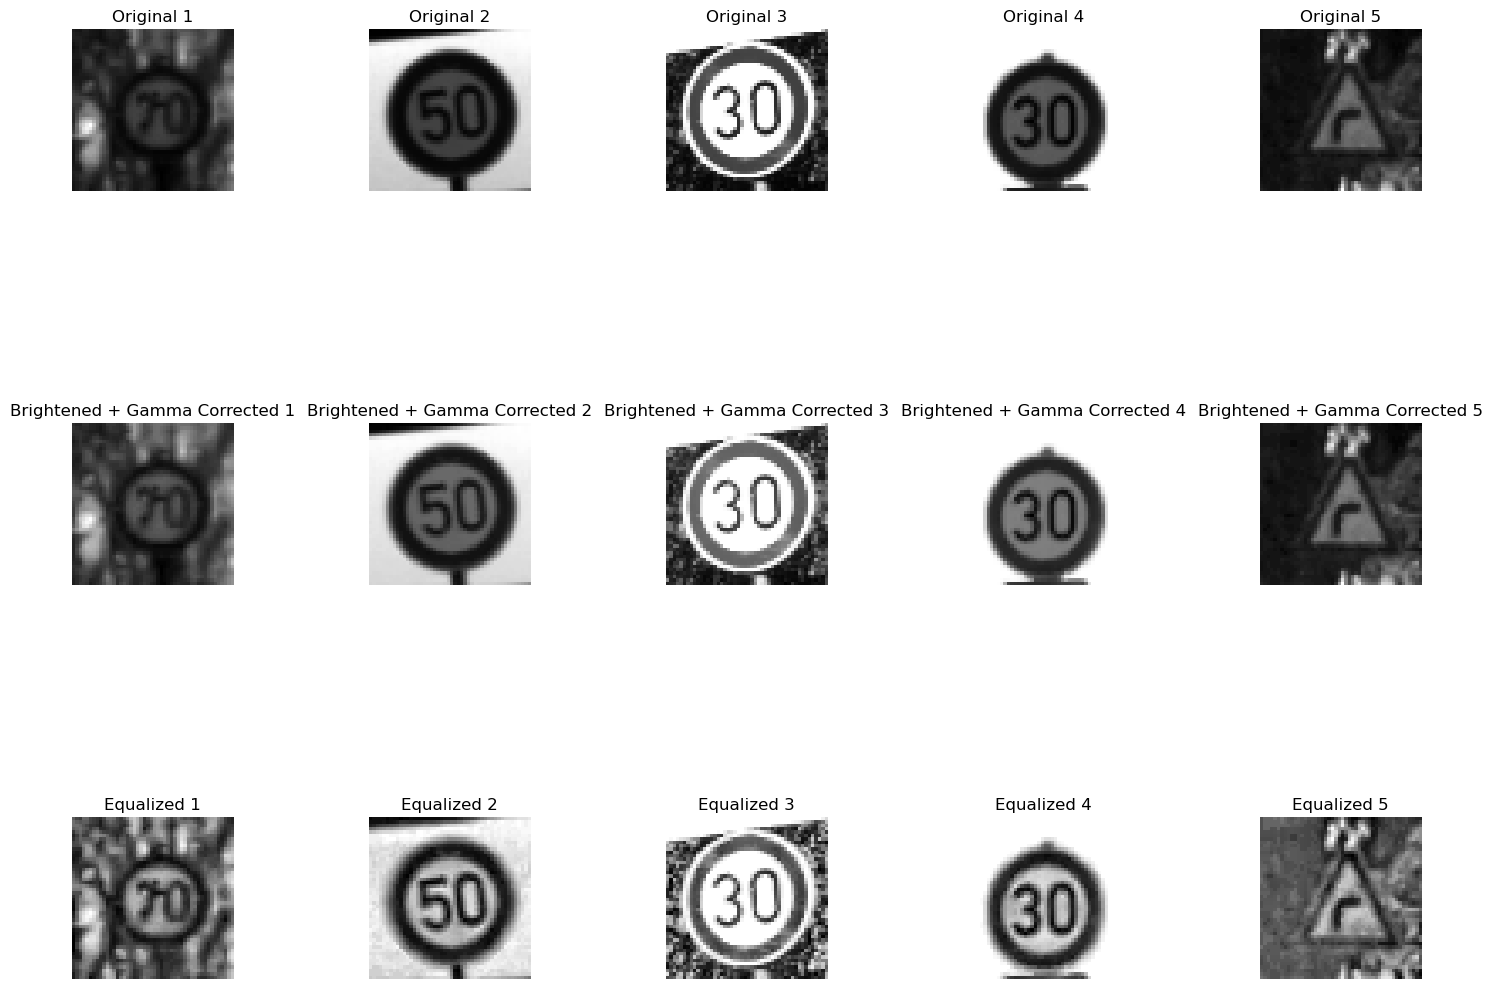

0    6
Name: 8293, dtype: int64

In [136]:
import matplotlib.pyplot as plt

x_copy = x_train.copy()

sample_size = 5
sample_indices = x_copy.sample(sample_size).index

num_rows = 4
num_cols = 5

plt.figure(figsize=(15, 10))


for i, idx in enumerate(sample_indices):
    plt.subplot(5, sample_size, i + 1)
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')
    
    brightened_image = brighten(x_copy.iloc[idx].values)
    gamma_image = apply_gamma_correction(x_copy.iloc[idx].values)

    plt.subplot(5, sample_size, 2 * sample_size + i + 1)
    gamma_image = gamma_image.reshape(48, 48)
    plt.imshow(gamma_image, cmap='gray')
    plt.title(f'Brightened + Gamma Corrected {i+1}')
    plt.axis('off')

    # noisy_image = add_noise(gamma_image)
    # blurred_image = apply_gaussian_blur(noisy_image, kernel_size=(5, 5), sigma=0)

    # plt.subplot(5, sample_size, 3 * sample_size + i + 1)
    # blurred_image = blurred_image.reshape(48, 48)
    # plt.imshow(blurred_image, cmap='gray')
    # plt.title(f'Noised + Gaussian Blurred {i+1}')
    # plt.axis('off')

    equalized_image = apply_clahe(gamma_image)  # Apply CLAHE

    plt.subplot(5, sample_size, 4 * sample_size + i + 1)
    equalized_image = equalized_image.reshape(48, 48)
    plt.imshow(equalized_image, cmap='gray')
    plt.title(f'Equalized {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()
y_train.iloc[idx]